# Linear Regression Analysis: Violent Crime and Socioeconomic Conditions

This python notebook outlines the regression analyses of socioeconomic conditions (unemployment rate, poverty rate, and housing vacancy rate) and violent crime in Washington, DC.

In [1]:
%matplotlib inline

# SQL Alchemy
from sqlalchemy import create_engine

# PyMySQL 
import pymysql
pymysql.install_as_MySQLdb()

# Config variables
from config import remote_db_endpoint, remote_db_port
from config import remote_dccrime_dbname, remote_dccrime_dbuser, remote_dccrime_dbpwd

# Import Pandas
import pandas as pd

# Import matplotlib and numpy
import matplotlib.pyplot as plt
import numpy as np

# Import modules from the sklearn library (for regression analysis)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Import crime and socioeconomic data from AWS

In [2]:
# Connect to remote AWS database
engine = create_engine(f"mysql://{remote_dccrime_dbuser}:{remote_dccrime_dbpwd}@{remote_db_endpoint}:{remote_db_port}/{remote_dccrime_dbname}")
conn = engine.connect()


In [3]:
# Import "crime_totals" data from AWS
crime_totals = pd.read_sql("SELECT * from crime_totals", conn)
crime_totals.head()

,ADW,Homicide,Robbery,Sex Abuse,BG
0,3.0,0.0,2.0,1.0,0001001
1,3.0,0.0,10.0,2.0,0001002
2,7.0,0.0,8.0,2.0,0001003
3,31.0,0.0,36.0,7.0,0001004
4,1.0,0.0,5.0,4.0,0002011


In [4]:
# Import "socioecon_data" data from AWS
socioecon_data = pd.read_sql("SELECT * from socioecon_data_update", conn)
socioecon_data.head()

,Block Group ID,GEOID,Total Population,Pct Poverty,Pct Unemployed,Pct Vacant
0,0001001,110010001001,1382.0,0.000000,0.000000,16.620879
1,0001002,110010001002,1463.0,3.075871,5.433746,15.702479
2,0001003,110010001003,972.0,1.440329,9.256449,16.603053
3,0001004,110010001004,1188.0,8.922559,3.095975,18.136439
4,0002011,110010002011,3733.0,1.473346,6.604938,0.000000


## Merge and clean datasets of crime and socioconomic data

In [5]:
# Merge crime and socioeconomic data on the corresponding block group ID fields.
merge_table = pd.merge(crime_totals, socioecon_data, left_on='BG', right_on='Block Group ID', how="outer")
merge_table.head()

,ADW,Homicide,Robbery,Sex Abuse,BG,Block Group ID,GEOID,Total Population,Pct Poverty,Pct Unemployed,Pct Vacant
0,3.0,0.0,2.0,1.0,0001001,0001001,110010001001,1382.0,0.000000,0.000000,16.620879
1,3.0,0.0,10.0,2.0,0001002,0001002,110010001002,1463.0,3.075871,5.433746,15.702479
2,7.0,0.0,8.0,2.0,0001003,0001003,110010001003,972.0,1.440329,9.256449,16.603053
3,31.0,0.0,36.0,7.0,0001004,0001004,110010001004,1188.0,8.922559,3.095975,18.136439
4,1.0,0.0,5.0,4.0,0002011,0002011,110010002011,3733.0,1.473346,6.604938,0.000000


In [6]:
# Add new column for all violent crime (calculated by individual crime type counts)
merge_table["Total_Violent_Crime"] = merge_table["ADW"] + merge_table["Homicide"] + merge_table["Robbery"] + merge_table["Sex Abuse"]
merge_table.head()

,ADW,Homicide,Robbery,Sex Abuse,BG,Block Group ID,GEOID,Total Population,Pct Poverty,Pct Unemployed,Pct Vacant,Total_Violent_Crime
0,3.0,0.0,2.0,1.0,0001001,0001001,110010001001,1382.0,0.000000,0.000000,16.620879,6.0
1,3.0,0.0,10.0,2.0,0001002,0001002,110010001002,1463.0,3.075871,5.433746,15.702479,15.0
2,7.0,0.0,8.0,2.0,0001003,0001003,110010001003,972.0,1.440329,9.256449,16.603053,17.0
3,31.0,0.0,36.0,7.0,0001004,0001004,110010001004,1188.0,8.922559,3.095975,18.136439,74.0
4,1.0,0.0,5.0,4.0,0002011,0002011,110010002011,3733.0,1.473346,6.604938,0.000000,10.0


In [7]:
# Rename dataframe column names to remove spaces and be more amenable to regression analyses
merge_table.rename(columns={'Sex Abuse':'Sex_Abuse',
                          'Block Group ID':'BG_ID',
                          'GEOID': 'GEOID',
                          'Total Population':'total_pop', 
                          'Pct Poverty':'pct_poverty',
                          'Pct Unemployed':'pct_unemployed',
                        'Pct Vacant':'pct_vacancy'},
                 inplace=True)

merge_table.tail()

,ADW,Homicide,Robbery,Sex_Abuse,BG,BG_ID,GEOID,total_pop,pct_poverty,pct_unemployed,pct_vacancy,Total_Violent_Crime
445,NaN,NaN,NaN,NaN,NaN,0007013,110010007013,1685.0,5.044510,2.575107,6.152584,NaN
446,NaN,NaN,NaN,NaN,NaN,0008012,110010008012,851.0,0.000000,6.341463,4.747774,NaN
447,NaN,NaN,NaN,NaN,NaN,0010021,110010010021,1345.0,62.304833,6.515152,24.381188,NaN
448,NaN,NaN,NaN,NaN,NaN,0013011,110010013011,1681.0,6.781678,5.035336,6.616729,NaN
449,NaN,NaN,NaN,NaN,NaN,0013013,110010013013,1615.0,2.848297,0.000000,5.476673,NaN


In [8]:
# The end of the merge table indicates that there are numerous block groups that do not have corresponding crime data,
# perhaps due to data-compilation error. These records are excluded here:
merge_table_final = merge_table[pd.notnull(merge_table['BG'])]
merge_table_final.tail()

,ADW,Homicide,Robbery,Sex_Abuse,BG,BG_ID,GEOID,total_pop,pct_poverty,pct_unemployed,pct_vacancy,Total_Violent_Crime
440,4.0,0.0,12.0,1.0,0110003,0110003,110010110003,686.0,5.102041,7.233273,8.053691,17.0
441,13.0,0.0,17.0,1.0,0110004,0110004,110010110004,1444.0,6.440443,2.185224,5.009107,31.0
442,82.0,1.0,105.0,10.0,0111001,0111001,110010111001,1731.0,10.456384,17.165899,10.174881,198.0
443,46.0,2.0,44.0,8.0,0111002,0111002,110010111002,2155.0,9.419954,13.886114,3.949224,100.0
444,79.0,3.0,79.0,6.0,0111003,0111003,110010111003,1639.0,35.143380,18.853695,17.616580,167.0


---

## Full Regression Analyses

This section runs the linear regression analyses and generates residual plots on each violent crime type and socioeconomic demographic relationship (each factor listed below). The linear regression plots show trend lines (in red).

Violent Crimes
1. All violent crimes
2. Assault with a Dangerous Weapon (ADW)
3. Robbery
4. Sex Abuse
5. Homicide

Socioeconomic Variables
1. Percent in poverty
2. Percent unemployed (from labor force)
3. Percent vacant housing units
4. Total population


### Percent Poverty x Total Violent Crime

Weight coefficients:  [[2.42154509]]
y-axis intercept:  [29.10257971]


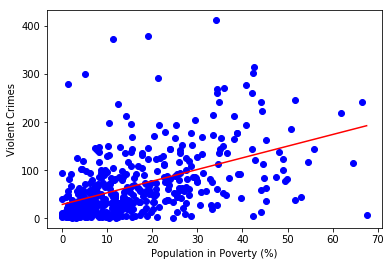

In [81]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.Total_Violent_Crime.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Population in Poverty (%)')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 3124.8215709690257
R-squared (R2 ): 0.191403330621723


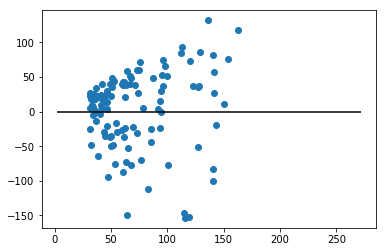

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
#plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
#plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

MSE: 0.6428740623975807, R2: 0.19140333062172288


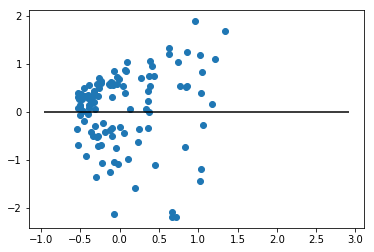

In [83]:
################# SCALING DATA #############

from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

model = LinearRegression()

model.fit(X_train_scaled, y_train_scaled)

y_predictions = model.predict(X_test_scaled)

model.fit(X_train_scaled, y_train_scaled)


plt.scatter(y_predictions, y_predictions - y_test_scaled)
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())

MSE = mean_squared_error(y_test_scaled, y_predictions)
r2 = r2_score(y_test_scaled, y_predictions)
print(f"MSE: {MSE}, R2: {r2}")



### Percent Unemployed x Total Violent Crime

Weight coefficients:  [[2.62371498]]
y-axis intercept:  [42.92295191]


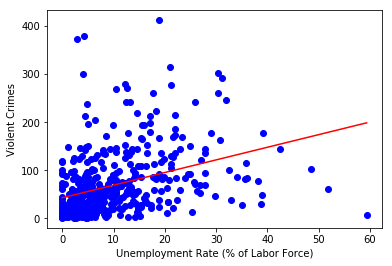

In [84]:
X = merge_table_final.pct_unemployed.values.reshape(-1, 1)
y = merge_table_final.Total_Violent_Crime.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Unemployment Rate (% of Labor Force)')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 3207.46291847133
R-squared (R2 ): 0.17001858374077594


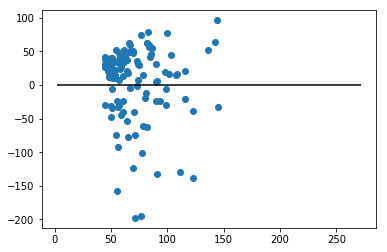

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

# =============================================

### Percent Vacant Units x Total Violent Crime

Weight coefficients:  [[1.68225421]]
y-axis intercept:  [52.19514742]


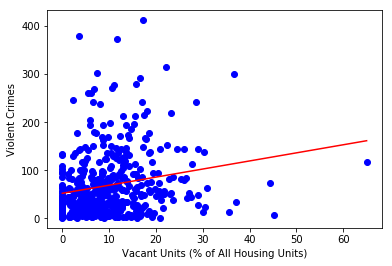

In [86]:
X = merge_table_final.pct_vacancy.values.reshape(-1, 1)
y = merge_table_final.Total_Violent_Crime.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Vacant Units (% of All Housing Units)')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 4025.7701841690937
R-squared (R2 ): -0.04173127606516025


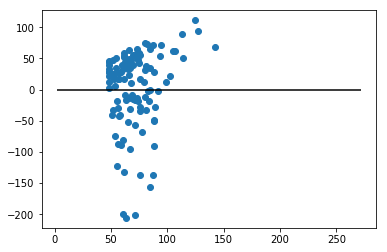

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

### Total Population x Total Violent Crime

Weight coefficients:  [[0.03048512]]
y-axis intercept:  [24.1591522]


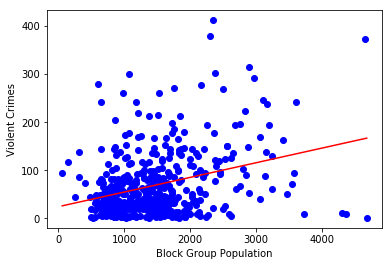

In [88]:
X = merge_table_final.total_pop.values.reshape(-1, 1)
y = merge_table_final.Total_Violent_Crime.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 3385.6347144220135
R-squared (R2 ): 0.12391383263391764


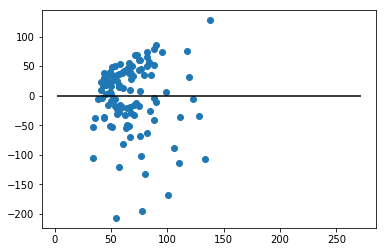

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

---

### Percent Poverty x ADW

Weight coefficients:  [[1.3497039]]
y-axis intercept:  [5.39205644]


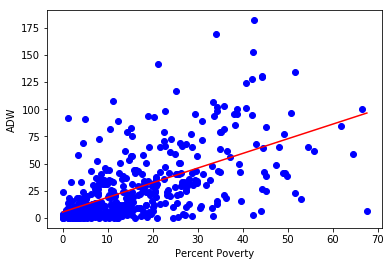

In [114]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.ADW.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Percent Poverty')
plt.ylabel('ADW')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 596.4784496091654
R-squared (R2 ): 0.29913121195336123


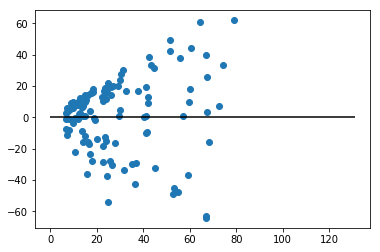

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

### Percent Unemployed x ADW

Weight coefficients:  [[1.59121199]]
y-axis intercept:  [11.82393756]


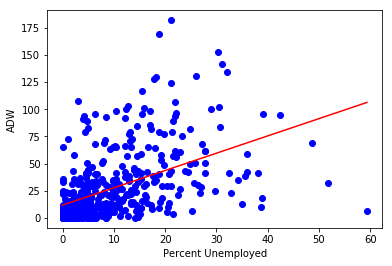

In [91]:
X = merge_table_final.pct_unemployed.values.reshape(-1, 1)
y = merge_table_final.ADW.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Percent Unemployed')
plt.ylabel('ADW')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 614.3213891960371
R-squared (R2 ): 0.2781655602158436


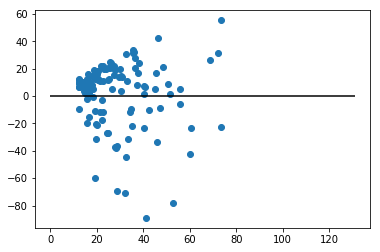

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

### Percent Vacancy x ADW

Weight coefficients:  [[0.88680822]]
y-axis intercept:  [18.76540889]


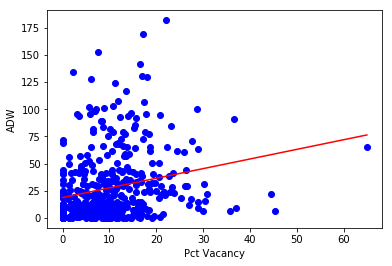

In [41]:
X = merge_table_final.pct_vacancy.values.reshape(-1, 1)
y = merge_table_final.ADW.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Pct Vacancy')
plt.ylabel('ADW')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 885.2969022708719
R-squared (R2 ): -0.04023367040768844


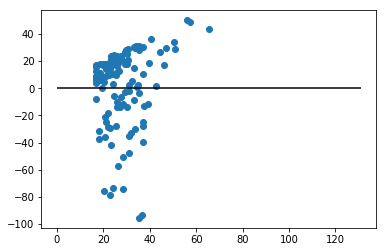

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

### Total Population x ADW

Weight coefficients:  [[0.01307258]]
y-axis intercept:  [8.37724294]


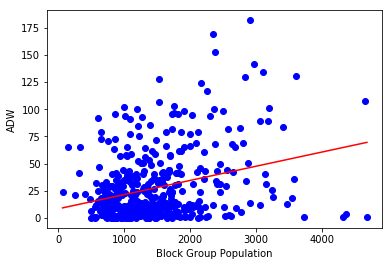

In [40]:
X = merge_table_final.total_pop.values.reshape(-1, 1)
y = merge_table_final.ADW.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('ADW')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 614.3213891960371
R-squared (R2): 0.2781655602158436


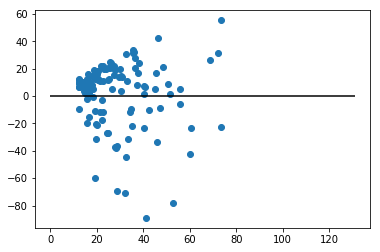

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

---

### Percent in Poverty x Robbery

Weight coefficients:  [[0.81961686]]
y-axis intercept:  [21.88045628]


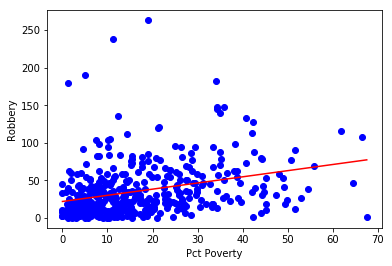

In [42]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.Robbery.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Pct Poverty')
plt.ylabel('Robbery')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 614.3213891960371
R-squared (R2): 0.2781655602158436


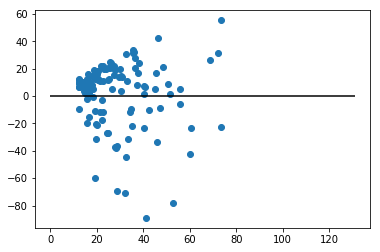

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

### Percent Unemployment x Robbery

Weight coefficients:  [[0.75372336]]
y-axis intercept:  [27.88368897]


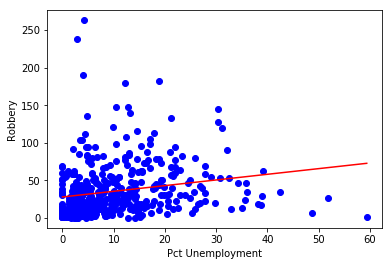

In [94]:
X = merge_table_final.pct_unemployed.values.reshape(-1, 1)
y = merge_table_final.Robbery.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Pct Unemployment')
plt.ylabel('Robbery')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 596.4784496091654
R-squared (R2): 0.29913121195336123


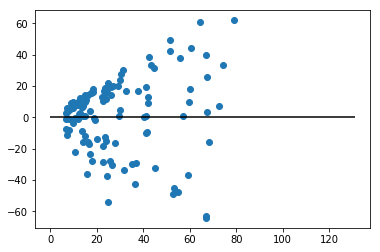

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

### Percent Vacancy x Robbery

Weight coefficients:  [[0.60850842]]
y-axis intercept:  [29.31013006]


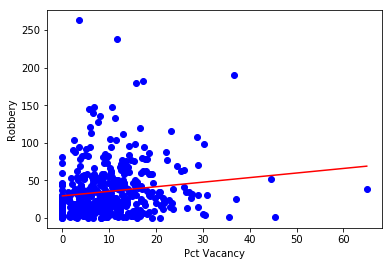

In [117]:
X = merge_table_final.pct_vacancy.values.reshape(-1, 1)
y = merge_table_final.Robbery.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Pct Vacancy')
plt.ylabel('Robbery')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 1010.370747449505
R-squared (R2): -0.02872918406925873


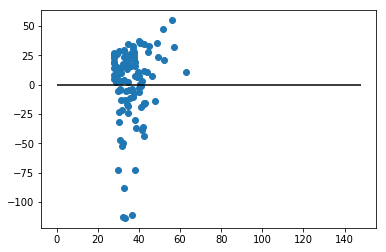

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

### Total Population x Robbery

Weight coefficients:  [[0.01424548]]
y-axis intercept:  [14.45469074]


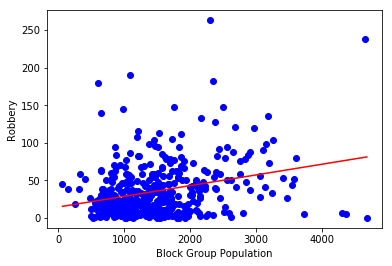

In [118]:
X = merge_table_final.total_pop.values.reshape(-1, 1)
y = merge_table_final.Robbery.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Robbery')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 898.9948534819657
R-squared (R2): 0.08467040990694852


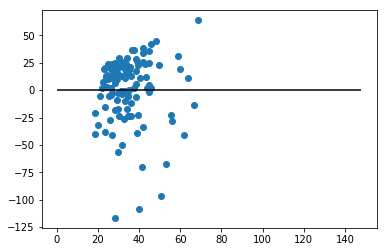

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

---

### Percent in Poverty x Sex Abuse

Weight coefficients:  [[0.11471458]]
y-axis intercept:  [2.21991986]


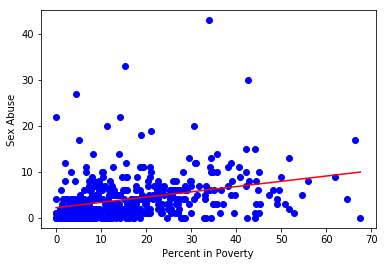

In [120]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.Sex_Abuse.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Percent in Poverty')
plt.ylabel('Sex Abuse')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 14.693156038027794
R-squared (R2): 0.065966566625007


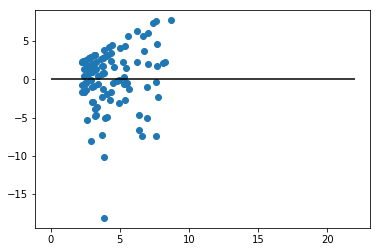

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

### Percent Unemployed x Sex Abuse

Weight coefficients:  [[0.13358982]]
y-axis intercept:  [2.78287393]


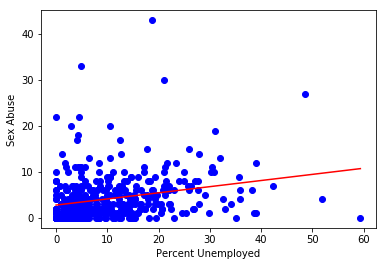

In [103]:
X = merge_table_final.pct_unemployed.values.reshape(-1, 1)
y = merge_table_final.Sex_Abuse.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Percent Unemployed')
plt.ylabel('Sex Abuse')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 13.747678689917846
R-squared (R2): 0.12606988624863458


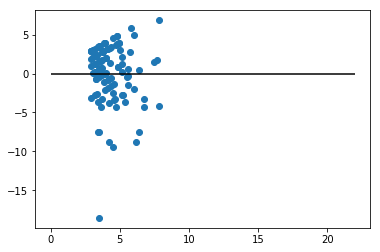

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

### Percent Vacancy x Sex Abuse

Weight coefficients:  [[0.1009318]]
y-axis intercept:  [3.10405753]


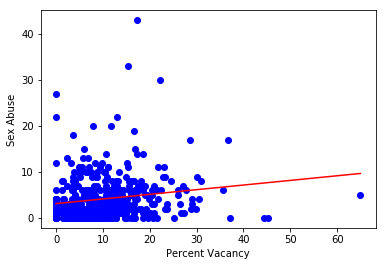

In [105]:
X = merge_table_final.pct_vacancy.values.reshape(-1, 1)
y = merge_table_final.Sex_Abuse.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Percent Vacancy')
plt.ylabel('Sex Abuse')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 16.50409833999233
R-squared (R2): -0.04915374187577903


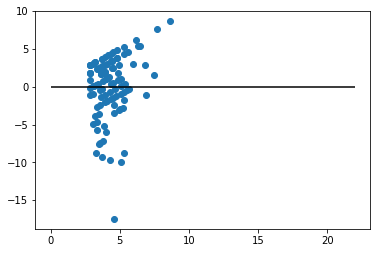

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

### Total Population x Sex Abuse

Weight coefficients:  [[0.00206985]]
y-axis intercept:  [1.0692259]


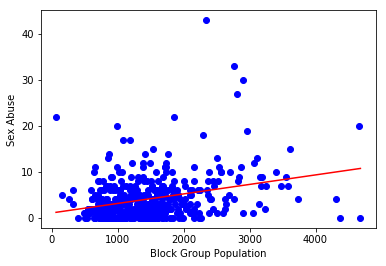

In [107]:
X = merge_table_final.total_pop.values.reshape(-1, 1)
y = merge_table_final.Sex_Abuse.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Sex Abuse')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 14.042625766224644
R-squared (R2): 0.10732031130137687


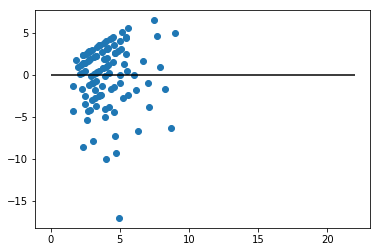

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

---

### Percent Poverty x Homicide

Weight coefficients:  [[0.13750974]]
y-axis intercept:  [-0.38985287]


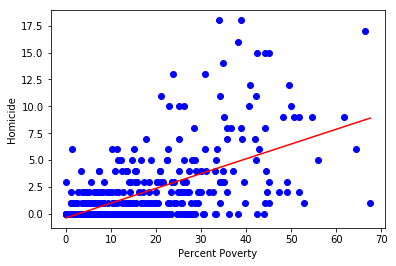

In [109]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.Homicide.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Percent Poverty')
plt.ylabel('Homicide')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 6.174202443793306
R-squared (R2): 0.34235231045247616


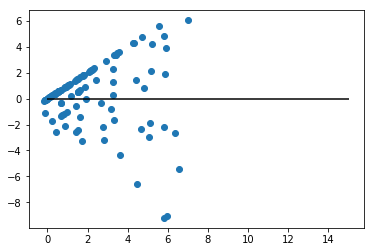

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

### Percent Unemployment x Homicide

Weight coefficients:  [[0.14518981]]
y-axis intercept:  [0.43245145]


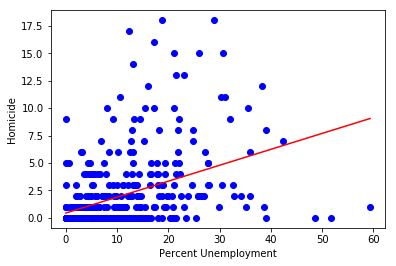

In [111]:
X = merge_table_final.pct_unemployed.values.reshape(-1, 1)
y = merge_table_final.Homicide.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Percent Unemployment')
plt.ylabel('Homicide')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 6.929004048297247
R-squared (R2): 0.26195430993537516


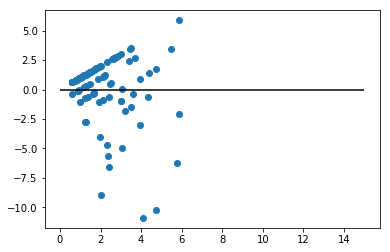

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=18)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

### Percent Vacancy x Homicide

Weight coefficients:  [[0.08600577]]
y-axis intercept:  [1.01555094]


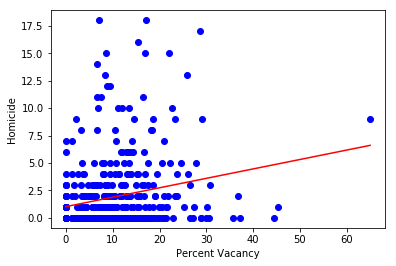

In [113]:
X = merge_table_final.pct_vacancy.values.reshape(-1, 1)
y = merge_table_final.Homicide.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Percent Vacancy')
plt.ylabel('Homicide')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 9.864378273467139
R-squared (R2): -0.05070827194691052


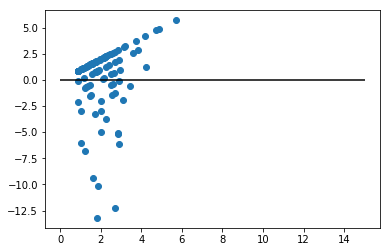

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

### Total Population x Homicide

Weight coefficients:  [[0.0010972]]
y-axis intercept:  [0.25799262]


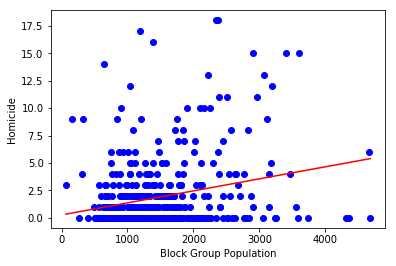

In [125]:
X = merge_table_final.total_pop.values.reshape(-1, 1)
y = merge_table_final.Homicide.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

pop_homicideX = X
pop_homicidey = y

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Homicide')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 8.387607643667751
R-squared (R2): 0.10659055353224345


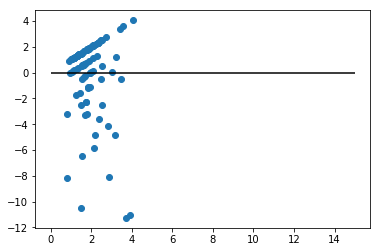

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")